In [1]:
# import required packages

import os
import itertools
import sys

from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import backend as K
from keras.callbacks import Callback
from keras.layers import Dense
from keras.models import Model
from PIL import Image

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Import training and testing data + rename label column
X_train = pd.read_csv('./X_train_update.csv', index_col=0)

y_train = pd.read_csv('./Y_train_CVw08PX.csv', index_col=0)
y_train = y_train.rename(columns={"prdtypecode": "label"})

X_test = pd.read_csv('./X_test_update.csv', index_col=0)



In [3]:
# Remove unecessary columns and create image id ['img_id']
X_train['filename'] = 'image_'+ X_train['imageid'].astype(str) + '_product_' + X_train['productid'].astype(str) + '.jpg'
del X_train['designation'], X_train['description'], X_train['productid'], X_train['imageid']

X_test['filename'] = 'image_'+ X_test['imageid'].astype(str) + '_product_' + X_test['productid'].astype(str) + '.jpg'
del X_test['designation'], X_test['description'], X_test['productid'], X_test['imageid']

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(84916, 1)
(84916, 1)
(13812, 1)


In [5]:
# Convert label from string to list of one element (required for the approach)
labels_list = []
for i in y_train['label']:
    label = []
    label.append(i)
    labels_list.append(label)
y_train['label'] = labels_list


X_train['label'] = y_train['label']

instantiate the ImageDataGenerator

In [6]:
X_train.dtypes

filename    object
label       object
dtype: object

In [7]:
img_gen = ImageDataGenerator(validation_split=0.2)


In [8]:
images_dir = Path('./data/images/images/image_train')

In [9]:
img_iter = img_gen.flow_from_dataframe(
    X_train,
    shuffle=True,
    directory=images_dir,
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=100,
    subset='training'
)

Found 67933 validated image filenames belonging to 27 classes.


In [10]:

img_iter_val = img_gen.flow_from_dataframe(
    X_train,
    shuffle=False,
    directory=images_dir,
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=100,
    subset='validation'
)

Found 16983 validated image filenames belonging to 27 classes.


In [11]:
# h initialising the model by specifying that the model is a sequential model
model = Sequential()

#2 x convolution layer of 64 channel of 3x3 kernal and same padding
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

#1 x maxpool layer of 2x2 pool size and stride 2x2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# 2 x convolution layer of 128 channel of 3x3 kernal and same padding
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

#1 x maxpool layer of 2x2 pool size and stride 2x2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#3 x convolution layer of 256 channel of 3x3 kernal and same padding
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

# 1 x maxpool layer of 2x2 pool size and stride 2x2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#3 x convolution layer of 512 channel of 3x3 kernal and same padding
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

#1 x maxpool layer of 2x2 pool size and stride 2x2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#3 x convolution layer of 512 channel of 3x3 kernal and same padding
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

#1 x maxpool layer of 2x2 pool size and stride 2x2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#flattenig the vector after convolution
model.add(Flatten())

#1x Dense layer of 4096 units
model.add(Dense(units=4096,activation="relu"))

#1x Dense layer of 4096 units
model.add(Dense(units=4096,activation="relu"))

# #1x Dense layer of 4096 units
# model.add(Dense(units=4096,activation="relu"))

#1 x Dense Softmax layer of 27 units
# (because we have 27 classes)
model.add(Dense(units=27, activation="softmax"))

Note - Precision, Recall and F1  metrics are all global metrics, but Keras works in batches. 

As a result, it might be more misleading than helpful.

In [12]:
#compiling the model and manually defining the F1 score

from keras import backend as K

# def recall_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

# def precision_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compiling the model

from keras.optimizers import Adam
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Summarizing the model

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

 Import ModelCheckpoint and EarlyStopping method from keras. 
 
 Will create an object of both and pass that as callback functions to fit_generator

In [15]:

#---------------------------------------------------------------------
from keras.callbacks import ModelCheckpoint, EarlyStopping

modelpath = "./data/VGG16_1.hdf5"

checkpoint = ModelCheckpoint(filepath= modelpath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


hist = model.fit_generator(steps_per_epoch=100,generator=img_iter, 
                          validation_data= img_iter_val, validation_steps=10,epochs=50,callbacks=[checkpoint,early])


Epoch 1/50
100/100 [==============================] - 160s 2s/step - loss: 3.0941 - accuracy: 0.1234 - val_loss: 3.0230 - val_accuracy: 0.1430

Epoch 00001: val_accuracy improved from -inf to 0.14300, saving model to ./data/VGG16_1.hdf5
Epoch 2/50
100/100 [==============================] - 159s 2s/step - loss: 3.1067 - accuracy: 0.1208 - val_loss: 3.1351 - val_accuracy: 0.1010

Epoch 00002: val_accuracy did not improve from 0.14300
Epoch 3/50
100/100 [==============================] - 159s 2s/step - loss: 3.0952 - accuracy: 0.1223 - val_loss: 2.9634 - val_accuracy: 0.1690

Epoch 00003: val_accuracy improved from 0.14300 to 0.16900, saving model to ./data/VGG16_1.hdf5
Epoch 4/50
100/100 [==============================] - 166s 2s/step - loss: 2.8858 - accuracy: 0.1661 - val_loss: 2.6945 - val_accuracy: 0.2140

Epoch 00004: val_accuracy improved from 0.16900 to 0.21400, saving model to ./data/VGG16_1.hdf5
Epoch 5/50
100/100 [==============================] - 159s 2s/step - loss: 2.6364 - 

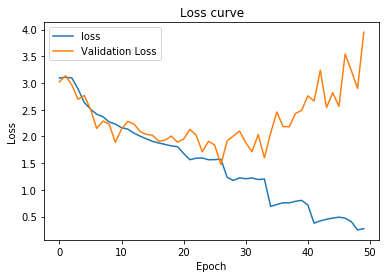

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

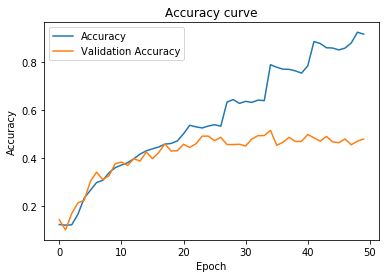

In [17]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Accuracy curve")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

In [19]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    directory='./data/images/images/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 13812 images belonging to 1 classes.


In [20]:
len(test_generator)

13812

In [21]:
from keras.models import load_model


saved_model = load_model('./data/VGG16_1.hdf5')

output = saved_model.predict_generator(test_generator, verbose=1, steps= len(test_generator))

13812/13812 [==============================] - 154s 11ms/step


In [22]:
predicted_class_indices=np.argmax(output,axis=1)
labels = (img_iter.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [23]:
filenames=test_generator.filenames
results=pd.DataFrame({"filename":filenames,
                      "Predictions":predictions})

In [24]:
results.head(5)

,filename,Predictions
0,image_test/image_1000095714_product_345301179.jpg,1160
1,image_test/image_1000139370_product_353636820.jpg,1320
2,image_test/image_1000221680_product_353626686.jpg,2280
3,image_test/image_1000434342_product_352882477.jpg,2403
4,image_test/image_1000524141_product_357695994.jpg,2585


# saving the final reslut to a csv

In [26]:
# Merging is not working
df_merged = pd.merge(left=X_test, right=results, on='filename', right_index=True)
df_merged = df_merged.drop(['filename'], axis=1)
df_merged = df_merged.rename(columns={'Predictions':'prdtypecode'})
df_merged.head(5)

In [ ]:
df_merged.to_csv('./result.csv', encoding='utf-8', index=True)